## 다른 Calibration Tech 이용


- Bottom Image 사용 X 그냥 밝기/대조/채도 조정

In [2]:
import pandas as pd
import numpy as np
from PIL import Image 
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import cv2

In [3]:
Thickness = pd.read_csv('./data/Thickness.csv')
Thickness = Thickness.drop([33]) # 9-1 drop
Thickness.reset_index(drop=True, inplace=True)

top_path = './data/box_img/Top/'

top_path_list = [f'./data/box_img/Top/Top_{i}.jpg' for i in range(0, 127)]

In [5]:
import cv2

def enhance_image(image_path, brightness, contrast, saturation, name):
    # 이미지 로드
    image = cv2.imread(image_path)
    
    # 밝기 조정
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    v = cv2.add(v, brightness)
    v = np.where(v < 0, 0, np.where(v > 255, 255, v))
    enhanced_hsv = cv2.merge((h, s, v))
    enhanced_image = cv2.cvtColor(enhanced_hsv, cv2.COLOR_HSV2BGR)
    
    # 콘트라스트 조정
    enhanced_image = cv2.convertScaleAbs(enhanced_image, alpha=contrast, beta=0)
    
    # 채도 조정
    enhanced_image = cv2.cvtColor(enhanced_image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(enhanced_image)
    s = cv2.add(s, saturation)
    s = np.where(s < 0, 0, np.where(s > 255, 255, s))
    enhanced_hsv = cv2.merge((h, s, v))
    enhanced_image = cv2.cvtColor(enhanced_hsv, cv2.COLOR_HSV2BGR)
    
    # 보정된 이미지 저장
    cv2.imwrite(f'./data/box_img/enhanced/Top_{name}.jpg', enhanced_image)

for i in range(0, 127):
    enhance_image(top_path_list[i], 50, 1.2, 1.0, i)
    
enhanced_top_path_list = [f'./data/box_img/enhanced/Top_{i}.jpg' for i in range(0, 127)]

- Reference 보정을 위해 기본값을 정하고 Weight를 줘서 보정을 해주면 되지 않을까?

### AutoML 먼저 시도

In [6]:
enhanced_top_avg_rgb = []
for i in range(len(enhanced_top_path_list)):
    top = Image.open(enhanced_top_path_list[i])
    top = np.array(top)
    Top_R, Top_G, Top_B = np.mean(top[:,:,0]), np.mean(top[:,:,1]), np.mean(top[:,:,2])
    
    enhanced_top_avg_rgb.append([Top_R, Top_G, Top_B])

In [7]:
enhanced_top_avg_rgb = np.array(enhanced_top_avg_rgb)

In [8]:
#top avg rgb + thickness
Table_dataset = pd.DataFrame(np.concatenate([enhanced_top_avg_rgb, Thickness], axis = 1), columns=['R', 'G', 'B', 'Thickness'])
Table_dataset

,R,G,B,Thickness
0,73.4828,69.1824,50.5084,48.266667
1,73.1220,74.5408,64.8804,47.966667
2,74.2320,74.2196,56.5988,48.166667
3,70.9512,72.8420,55.0280,48.600000
4,65.0448,39.8172,15.3372,59.533333
...,...,...,...,...
122,2.1528,18.9564,86.5948,84.633333
123,2.1468,46.2852,100.2784,98.366667
124,2.5064,35.8752,106.2152,97.033333
125,2.4492,39.2576,102.5204,96.266667


In [9]:
X_train, X_test, y_train, y_test = train_test_split(Table_dataset.iloc[:,:-1], Table_dataset.iloc[:,-1], test_size=0.3, random_state=42)

In [10]:
from tpot import TPOTRegressor

tpot =  TPOTRegressor(generations=5, population_size=50, verbosity=2, random_state=42, cv=5, n_jobs = -1)
tpot.fit(X_train, y_train)

tpot.export('tpot_corrected.py')

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Best pipeline: AdaBoostRegressor(DecisionTreeRegressor(input_matrix, max_depth=4, min_samples_leaf=1, min_samples_split=20), learning_rate=0.01, loss=exponential, n_estimators=100)


In [11]:
y_pred = tpot.predict(X_test)
y_pred

c:\Users\se99a\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


array([ 74.60666667,  62.65333333,  74.59111111,  97.20000001,
        97.12916667,  62.65333333,  74.50144928,  96.79473684,
        62.64242424, 111.69999999,  97.12916667,  62.65333333,
        83.0375    ,  62.61333333,  84.65066667, 102.39791666,
        84.74901961,  83.0375    ,  62.65333333,  83.18947369,
        62.925     ,  62.65333333,  84.65066667, 153.3       ,
        61.55      , 124.4333333 , 101.43809524, 101.43809524,
        74.59111111,  83.62833333,  62.65333333,  74.40757576,
        74.50144928, 111.5222222 ,  96.79473684, 100.81818182,
        74.60666667, 153.3       ,  74.80333333])

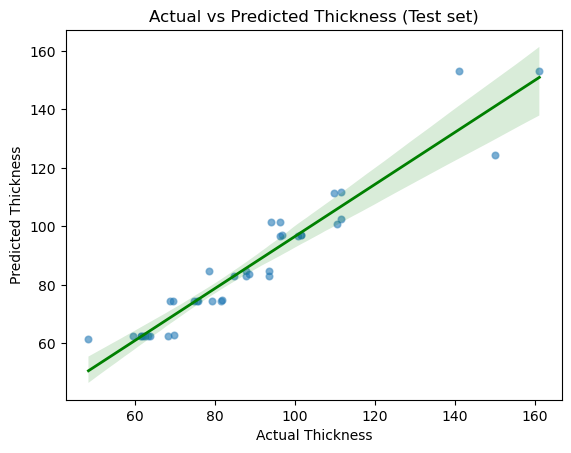

In [12]:
import statsmodels.api as sm
import seaborn as sns

# 그래프 그리기
sns.scatterplot(x=y_test, y=y_pred, alpha=0.4)
sns.regplot(x=y_test, y=y_pred, scatter_kws={'s': 20, 'alpha':0.3}, line_kws={'color':'green', 'linewidth': 2}, robust=True)

plt.xlabel('Actual Thickness')
plt.ylabel('Predicted Thickness')
plt.title('Actual vs Predicted Thickness (Test set)')
plt.show()

In [13]:
pd.DataFrame({'True': y_test.values, 'Predict': y_pred})

,True,Predict
0,75.533333,74.606667
1,61.300000,62.653333
2,68.700000,74.591111
3,96.633333,97.200000
4,101.466667,97.129167
5,63.166667,62.653333
6,69.433333,74.501449
7,96.266667,96.794737
8,61.466667,62.642424
9,111.533333,111.700000


In [14]:
from sklearn.metrics import mean_squared_error
# 테스트 세트에서의 RMSE 계산
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('MSE: {0:.3f}, RMSE: {1:.3f}'.format(mse, rmse))

MSE: 48.951, RMSE: 6.997
